<a href="https://colab.research.google.com/github/5x5x5x5/5x5x5x5.github.io/blob/master/Simple_neural_network_in_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Feynman said: "If you cannot explain something in simple terms, you don't understand it."

I have a slightly different perspective; if you cannot _implement_ something using basic fundamentals, you don't understand it.

As such- I realized that I don't actually [understand how backprop works](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b), as I can't implement it. So this notebook is my attempt to fix this.

Note: This is inspired by, among other articles, [Daniel Daza's notebook](https://dfdazac.github.io/06-neural-networks-numpy.html).

We don't worry about batching here to simplify things; if we wanted to, we could easily batch everything by using JAX's [`vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) function. 

We also aren't worried about overfitting here, but _you_ probably should be. Never implement an actual ML algorithm without a proper training/testing split.

In [ ]:
#@title Imports
import numpy as np
import dataclasses
from sklearn import datasets
from typing import List, Callable, Tuple
from matplotlib import pyplot as plt

Ok! So our goal is to train a simple neural network to solve the [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons) task. In this problem, we have two overlapping semi-circles.

Here are some functions to plot the data:

In [ ]:
def plot_labels(inputs: np.ndarray, labels: np.ndarray):
  plt.scatter(inputs[labels == 0, 0], inputs[labels == 0, 1], label="class 0")
  plt.scatter(inputs[labels == 1, 0], inputs[labels == 1, 1], label="class 1")
  plt.legend()
  plt.show()

def plot_predictions(inputs: np.ndarray, true_labels: np.ndarray, predicted_labels: np.ndarray):
  plt.title('True labels')
  plot_labels(inputs, true_labels)
  plt.title('Predicted labels')
  plot_labels(inputs, predicted_labels)

In [ ]:
inputs, labels = datasets.make_moons(100)

And this is what the data looks like:

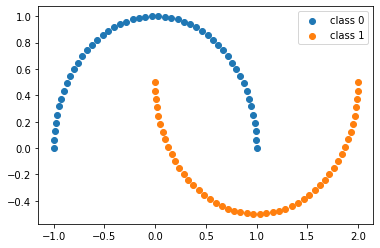

In [ ]:
plot_labels(inputs, labels)

We want to distinguish them using a multi-layer perceptron (MLP), i.e. neural network composed of linear layers with ReLU activations. Our network will end with a softmax activation so that it outputs probabilities. We will use the multi-class cross-entropy loss as our loss function.

The ReLU activation function is defined by:

$$
\text{ReLU}(x) := \max(0, x), x \in \mathbb{R}^n
$$

the softmax function is defined by:

$$
\text{softmax}(x) := \dfrac{\exp(x)}{ \sum_{i=1}^n \exp(x_i)}, x \in \mathbb{R}^n,
$$

and the multi-class cross-entropy loss is given by

$$
L(\hat{y}, y) := \sum_{i= 1}^n y_i \log \hat{y}, \text{ where } y, \hat y \in \mathbb{R}^k.
$$

Note that, while the two are mathematically equivalent, we will instead use the rescaled version of the softmax function, as it is more numerically stable:

$$
\text{softmax}(x) := \dfrac{\exp(x - \max_{i=1,\ldots, n} x_i)}{ \sum_{i=1}^n \exp(x_i - \max_{i=1,\ldots, n} x_i)}, x \in \mathbb{R}^n.
$$

We also need to calculate the derivatives of these functions to be able to calculate the gradients of our loss function. We have:

\begin{align}
  \text{ReLU}'(x) &= \begin{cases} 1 & x_i > 0 \\ 0 & x_i <= 0 \end{cases}\\
  \text{softmax}'(x) &= \text{softmax}(x) (1 - \text{softmax}(x))\\
  \frac{\partial L(\hat{y}, y)}{\partial \hat{y}_i} &= \frac{y_i}{\hat{y}_i}.
\end{align}

In [ ]:
def _relu(inputs: np.ndarray) -> np.ndarray:
  return np.maximum(inputs, np.zeros_like(inputs))


def _softmax(inputs: np.ndarray) -> np.ndarray:
  exp_inputs = np.exp(inputs - np.max(inputs))
  return exp_inputs / np.sum(exp_inputs)


def _relu_derivative(inputs: np.ndarray) -> np.ndarray:
  return np.where(inputs > 0, np.ones_like(inputs), np.zeros_like(inputs))


def _softmax_derivative(inputs: np.ndarray) -> np.ndarray:
  softmax = _softmax(inputs)
  return softmax * (1 - softmax)


def _get_activation(function_name: str) -> Callable[[np.ndarray], np.ndarray]:
  if function_name == 'relu':
    return _relu
  elif function_name == 'softmax':
    return _softmax
  else:
    raise ValueError(f'Unknown function_name: {function_name=}.')


def _get_activation_derivative(function_name: str) -> Callable[[np.ndarray], np.ndarray]:
  if function_name == 'relu':
    return _relu_derivative
  elif function_name == 'softmax':
    return _softmax_derivative
  else:
    raise ValueError(f'Unknown function_name: {function_name=}.')


def cross_entropy(prediction: np.ndarray, label: np.ndarray) -> float:
  return -1 * np.log(prediction)[label]


def cross_entropy_derivative(prediction: np.ndarray, label: int) -> float:
  return -1. / prediction[label]

def mean_squared_error(prediction: np.ndarray, label: int) -> float:
  one_hot = np.zeros_like(prediction)
  one_hot[label] = 1
  return np.mean((prediction - one_hot) ** 2)

def mean_squared_error_derivative(prediction: np.ndarray, label: int) -> float:
  one_hot = np.zeros_like(prediction)
  one_hot[label] = 1
  return prediction - one_hot

Now, to run our code, we'll need to initialize the parameters for our neural network. We'll follow standard practice and initialize the weights following the Glorot distribution, and initialize the biases to be a small positive constant.

In [ ]:
# We use a dataclass here to provide a convenient grouping for everything that
# makes up our layer.
@dataclasses.dataclass
class LayerParams:
  weights: np.ndarray
  biases: np.ndarray
  activation: Callable[[np.ndarray], np.ndarray]


def _glorot_scale(in_dims: int, out_dims: int) -> float:
  return np.sqrt(2 / (in_dims + out_dims))


def _initialize_weights(in_dims: int, out_dims: int) -> np.ndarray:
  return np.random.normal(loc=0., 
                          scale=_glorot_scale(in_dims, out_dims),
                          size=(in_dims, out_dims))



def init_params(sizes: List[int]) -> List[LayerParams]:
  """Initializes the layer params for a MLP.

  Args:
    sizes: List of network sizes. Must include input size as the 0th layer.

  Returns:
    params for network.
  """
  params = []
  for size_index in range(len(sizes) - 1):
    in_dims = sizes[size_index]
    out_dims = sizes[size_index + 1]
    if size_index == len(sizes) - 2:
      activation = 'softmax'
    else:
      activation = 'relu'
    params.append(LayerParams(weights=_initialize_weights(in_dims, out_dims),
                              biases=0.01 * np.ones(out_dims),
                              activation=activation))
  return params

Now, our forward pass! It's pretty straightforward, because we're restricting
our code to only support MLPs. 

For each layer, we do the following calculation (where $A_i$ is the output of each layer, $X_i$ is the input, $f_i$ is the activation function, and $W_i/b_i$ are the weight matrix and bias vectors): 

$$
X_i = f_i(W_i^T X_i + b_i).
$$

Note that $W_i \in \mathbb{R}^{m \times n}, X_i \in \mathbb{R}^m,$ and $A_i, b_i \in \mathbb{R}^n$.

In [ ]:
def forward_with_activations(
    params: List[LayerParams], 
    image: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
  """Does a forward pass of our MLP.
  
  Args:
    params: The weights/biases of our MLP.
    image: The image we want to do inference on.

  Returns:
    The output of the neural network- here, probabilities of each class.
  """
  layer_input = image
  activations = []
  for layer_index, layer_params in enumerate(params):
    layer_output = np.matmul(layer_input, layer_params.weights)
    layer_output += layer_params.biases
    layer_output = _get_activation(layer_params.activation)(layer_output)
    layer_input = layer_output
    activations.append(layer_output)
  return layer_output, activations

That's it! It's that simple. We do one additional task here other than just calculating the forward pass of the network: we cache the activations. That is because we will need them for the backwards pass, and we don't want to have to recompute them.

We're going to add some helper functions to make our life easier, and then, on to our backwards pass!

In [ ]:
def calculate_loss(params: List[LayerParams], image: np.ndarray, label: int) -> float:
  prediction, _ = forward_with_activations(params, image)
  return cross_entropy(prediction, label)


def accuracy(params: List[LayerParams], 
             images: np.ndarray, labels: np.ndarray) -> float:
  num_correct = 0
  for data_index in range(len(labels)):
    image, label = images[data_index, :], labels[data_index]
    prediction = np.argmax(forward_with_activations(params, image)[0])
    num_correct += prediction == label
  return num_correct / len(images)

def predict_labels(params: List[LayerParams], inputs: np.ndarray):
  predicted_labels = []
  for image in inputs:
    probabilities, _ = forward_with_activations(params, image)
    prediction = np.argmax(probabilities)
    predicted_labels.append(prediction)
  return np.array(predicted_labels)

Ok! Time for our backwards pass.

In order to update each weight matrix $W_i$ and each bias vector $b_i$, we want to calculate the gradients for each: $\nabla_{W_i} L, \nabla_{b_i} L$. Once we have these, we can use gradient descent to do our update:

\begin{align}
  W_i &= W_i - \eta \nabla_{W_i} L\\
  b_i &= b_i - \eta \nabla_{b_i} L\\
\end{align}

In [ ]:
LEARNING_RATE = 1e-3

def backward(params: List[LayerParams], image: np.ndarray, 
             label: int) -> List[LayerParams]:
  probabilities, activations = forward_with_activations(params, image)
  accumulated_gradient = mean_squared_error_derivative(probabilities, label)
  new_params = [None for _ in params]
  for reverse_layer_index, layer_params in enumerate(reversed(params)):

    # We'll do some basic bookkeeping here to make things simpler to read.
    layer_index = len(params) - 1 - reverse_layer_index
    activation_derivative_func = _get_activation_derivative(
        layer_params.activation)
    prev_activation = activations[layer_index - 1]
    activation_derivative = activation_derivative_func(activations[layer_index])
    bias_gradient = accumulated_gradient * activation_derivative
    weight_gradient = np.outer(prev_activation, bias_gradient.T)
    #weight_gradient = np.expand_dims(prev_activation, axis=1) @ np.expand_dims(bias_gradient, axis=1).T

    # Now, we finally do our SGD step. Note that we could easily use a fancier
    # optimizer here.
    new_biases = layer_params.biases - LEARNING_RATE * bias_gradient
    new_weights = layer_params.weights - LEARNING_RATE * weight_gradient
    new_params[layer_index] = LayerParams(weights=new_weights,
                                          biases=new_biases,
                                          activation=layer_params.activation)
    # Finally, we update our accumulated gradient with the current weights. This
    # gets it ready for the next iteration.
    accumulated_gradient = np.dot(bias_gradient, layer_params.weights.T)
  return new_params


In [ ]:
params = init_params([2, 128, 128, 128, 128, 2])

Let's take our newly initialized `params`, and see how well our network does at predicting the labels!

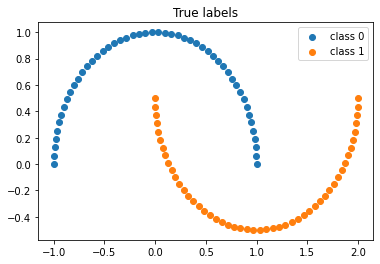

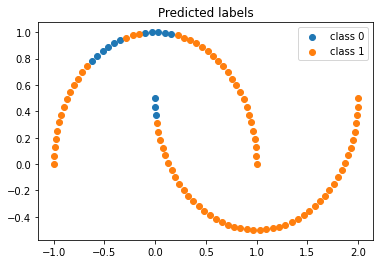

In [ ]:
plot_predictions(inputs, labels, predict_labels(params, inputs))

That's _really_ bad. Let's try training for 100 epochs and see if that makes things better.

In [ ]:
for epoch_index in range(100):
  loss = sum([calculate_loss(params, inputs[data_index, :], labels[data_index]) for data_index in range(len(labels))])/len(labels)
  print(f'Running epoch {epoch_index}, mean loss: {loss}, accuracy: {accuracy(params, inputs, labels)}')
  for data_index in range(len(labels)):
    image, label = inputs[data_index, :], labels[data_index]
    params = backward(params, image, label)

Running epoch 0, mean loss: 0.6882214695898781, accuracy: 0.58
Running epoch 1, mean loss: 0.6854501985699152, accuracy: 0.61
Running epoch 2, mean loss: 0.6827309327540704, accuracy: 0.63
Running epoch 3, mean loss: 0.6801400208936189, accuracy: 0.65
Running epoch 4, mean loss: 0.6776429090581089, accuracy: 0.68
Running epoch 5, mean loss: 0.6752330215798363, accuracy: 0.73
Running epoch 6, mean loss: 0.6728452709859283, accuracy: 0.74
Running epoch 7, mean loss: 0.670520127267018, accuracy: 0.77
Running epoch 8, mean loss: 0.6682078969943137, accuracy: 0.78
Running epoch 9, mean loss: 0.6658363763023019, accuracy: 0.78
Running epoch 10, mean loss: 0.6634406801002148, accuracy: 0.78
Running epoch 11, mean loss: 0.66109898428573, accuracy: 0.78
Running epoch 12, mean loss: 0.6587899161282852, accuracy: 0.79
Running epoch 13, mean loss: 0.6565048536413284, accuracy: 0.79


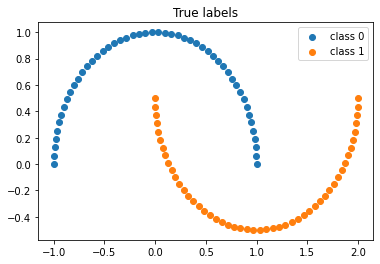

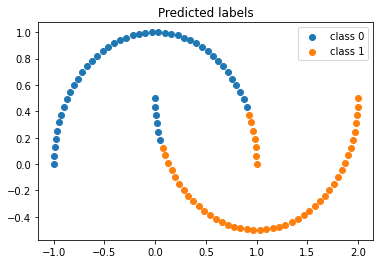

In [ ]:
plot_predictions(inputs, labels, predict_labels(params, inputs))

That's pretty good! Not perfect, but much better. Our network now correctly classifies 86% of the items.

There's a lot more things we could do here- for instance, hyper-parameter sweeps, or mini-batching, but we'll just leave this here for simplicity's sake. 